# Synthetic sea surface elevation from CDIP directional wave spectrum

Author: Bia Villas Bôas - avillasboas@ucsd.edu

This notebook takes the most spectral data from [CDIP buoy 029](http://cdip.ucsd.edu/m/products/?stn=029p1) (Point Reyes) and constructs a synthetic realization of the corresponding sea surface using superposition of linear waves and random phases. It uses the auxiliary functions `plot_dirSpec` and  `getmem`, both available in this repository.

In [1]:
from IPython.display import clear_output, HTML

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, cm
from matplotlib.animation import FuncAnimation
import xarray as xr
from scipy.signal import detrend

from getmem import GetMem
from plot_dirSpec import  plot_dirSpec
from tools import *

Here, we read the directional spectrum data directly from CDIP's website via OPeNDAP.

In [2]:
ds = xr.open_dataset('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/029p1_rt.nc')

We will use the most recent time (last value in the time dimension)

In [3]:
nctime = ds.isel(waveTime=-1).waveTime.values
print("The most recent time is:", nctime)

The most recent time is: 2021-07-06T01:00:00.000000000


Now, we read the frequencies and energy spectrum 

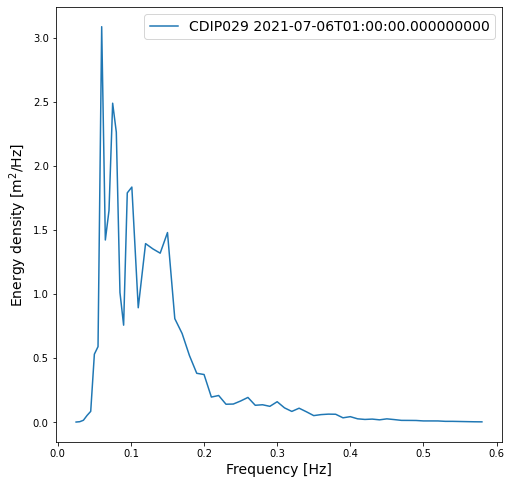

In [4]:
freq = ds['waveFrequency'].values # wave frequency
energy = ds['waveEnergyDensity'][-1].values

plt.figure(figsize=(8,8))
plt.plot(freq, energy, label='CDIP029 {0}'.format(nctime))
plt.ylabel("Energy density [m$^2$/Hz]", fontsize=14)
plt.xlabel("Frequency [Hz]", fontsize=14)
plt.legend(fontsize=14)

Operational wave buoys do not save the entire frequency-direction information. Instead, wave buoys usually save the first four directional Fourier coefficients. Here we use the Maximum Entropy Method to reconstruct the directional spectrum from the coefficients (see [Lygre et. al, 1986](https://journals.ametsoc.org/jpo/article/16/12/2052/6574) ).

In [5]:
a1 = ds['waveA1Value'][-1].values
b1 = ds['waveB1Value'][-1].values
a2 = ds['waveA2Value'][-1].values
b2 = ds['waveB2Value'][-1].values

Before reconstructing the spectrum let's check some of the bulk wave parameters computed by CDIP:

In [6]:
print("Peak wave direction:", ds['waveDp'][-1].values)
print("Peak wave period:", ds['waveTp'][-1].values)
print("Significant wave height:", ds['waveHs'][-1].values)

Peak wave direction: 181.34375
Peak wave period: 16.666667938232422
Significant wave height: 1.809999942779541


Now we reconstruct and plot the directional spectrum

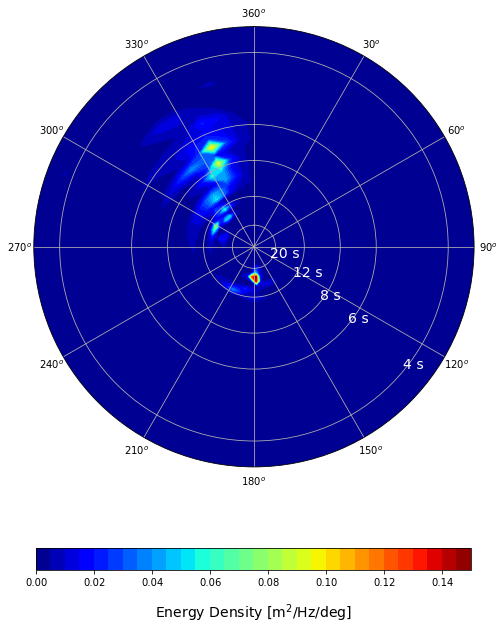

In [7]:
ndir = 48 # number of direction bins
E = np.tile(energy, (ndir,1)).T
norm_mem= GetMem(a1,b1,a2,b2, ndir=ndir) # This uses the auxiliary function GetMem
dirSpec = E*norm_mem
dirSpec = dirSpec.T
plot_dirSpec(dirSpec, freq, directions=None, vmin=0,filename=None) # This uses the auxiliary function plot_dirSpec

We can check the significant wave height by computing:
$$H_s = 4 \left[\int_{0^\circ}^{360^\circ} \int_0^\infty  E(f,\theta) df d\theta\right]^{1/2}
$$ 



In [8]:
df = ds['waveFrequencyBounds'][:,1].values - ds['waveFrequencyBounds'][:,0].values
ndir, nfreq = dirSpec.shape
dth = 360/ndir # delta theta in degrees
directions = np.arange(0, 360, dth)
dir_rad = np.radians(directions)

hs_reconstruct = 4*(np.sum(np.dot(dirSpec, df)*dth))**.5
print("The significan wave height from the directional spectrum is: {0}m".format(
    round(hs_reconstruct,2)))

The significan wave height from the directional spectrum is: 1.83m


Now, we assume the linear deep-water dispersion relationto compute the wavenumbers:

$$
\sigma^2 = g k
$$

In [9]:
g = 9.81
sig = 2*np.pi*freq # going from linear freq to angular
k = sig**2/g
lmax = 2*np.pi/k.min()
lmin = 2*np.pi/k.max()
print("max resolved wavelength = {0}m".format(lmax))
print("min resolved wavelength = {0}m".format(lmin))

max resolved wavelength = 2498.0958768706773m
min resolved wavelength = 4.641230539935751m


Let's we create a horizontal grid to construct ou synthetic sea surface.

In [10]:
L = 2000 # domain length
dx = 5 #grid spacing in x
x = np.arange(0,lmax, dx)
y = x
xx, yy = np.meshgrid(x, y)
print('If the units of x is meters, the grid spacing is {0} m'.format(round(x[1]-x[0]),2))
print('If the units of x is meters, the grid goes from {0} m to {1} m'.format(x[0], x[-1]))

If the units of x is meters, the grid spacing is 5 m
If the units of x is meters, the grid goes from 0.0 m to 2495.0 m


Considering that the sea surface results from the linear superposition of all waves (all frequencies and directions), the surface elevation can be writen as.

$$
\eta(x, y, t) = \sum_i \sum_j A[i, j] \ \cos(k_x[i] x + k_y[i] y + \phi[i, j]),
$$

where the amplitude of the Fourier coefficients  $A[i, j]$ is related to the spectral density by

$$
E(f, \theta) = \frac{1}{\Delta f \Delta \theta} \left< \frac{1}{2} A^2[i, j]\right>
$$

In [11]:
A = (2*dirSpec*df*dth)**.5 # Wave amplitudes from spectral densities

In [12]:
zeta = np.zeros(xx.shape)
E = 0
for i in range(ndir):
    for j in range(nfreq):
        kx = k[j]*np.cos(dir_rad[i]+np.pi)
        ky = k[j]*np.sin(dir_rad[i]+np.pi)
        phi = np.random.random()*2*np.pi # random phases
        zeta += A[i,j] * np.cos(kx*xx + ky*yy + phi) 

In [13]:
print("Hs computed from the synthetic sea surface elevation: {0}".format(4*(zeta).std()))

Hs computed from the synthetic sea surface elevation: 1.8458730279241817


Text(0.5, 1.0, 'Sea Surface Elevation')

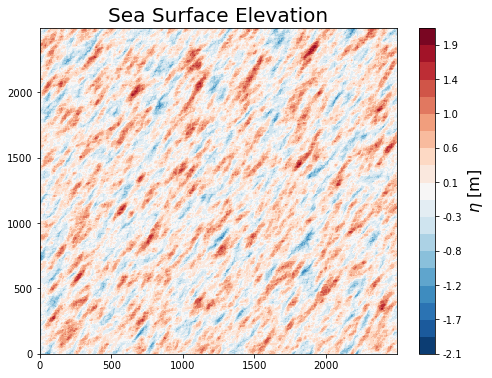

In [14]:
clim = np.max(abs(zeta))
lin = np.linspace(-clim, clim, 20)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zeta, lin, cmap = 'RdBu_r')
cbar = plt.colorbar(format='%.1f')
cbar.set_label('$\eta$ [m]', fontsize=16)
plt.title("Sea Surface Elevation", fontsize=20)

Now, let's verify if we can get back the directional spetrum that we started with. We start by computing the 2D FFT of the surface elevation. This will give us the 2D wavenumber spectrum (as a function of the kx and ky wavenumbers). To reduce the noise a bit, we will devided the sea surface elevation into 4 square tiles with 250x250 points each, and average the spectrum across the tiles.

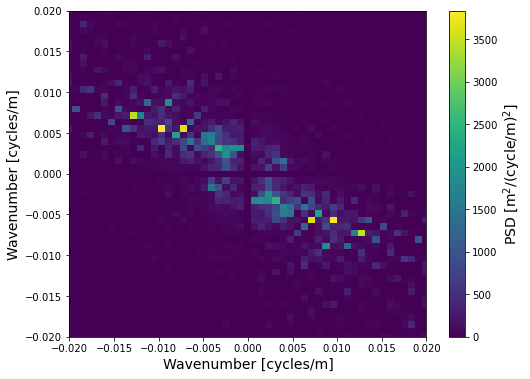

In [15]:
tiles = make_tiles(zeta, lenx=250, leny=250)
tiles_dmean = detrend(detrend(tiles, axis=(-1)), axis=-2) 
nx, ny = tiles[0].shape
Kx =  np.fft.fftshift(np.fft.fftfreq(nx, dx))
Ky = np.fft.fftshift(np.fft.fftfreq(ny, dx))
dkx = np.diff(Kx)[0]
dky = np.diff(Ky)[0]

phih = np.fft.fft2(tiles_dmean,axes=(-2,-1))
spec = (abs(phih)/(nx*ny))**2
var_dens = np.fft.fftshift(spec.copy(),axes=(-1,-2)) /dkx/dky
mean_spec = var_dens.mean(axis=0)
plt.figure(figsize=(8, 6))
cs = plt.pcolormesh(Kx, Ky, mean_spec, shading='auto')
plt.xlim([-0.02,0.02])
plt.ylim([-0.02,0.02])
plt.xlabel('Wavenumber [cycles/m]', fontsize=14)
plt.ylabel('Wavenumber [cycles/m]', fontsize=14)
cbar = plt.colorbar(cs)
cbar.set_label('PSD [m$^2$/(cycle/m)$^2$]', fontsize=14)

For now let's not worry about the units of the spectrum. The first thing we note, is that we will have a $180^\circ$ ambiguity in the resulting spectrum. Now, let's convert the spectrum from $[k_x, k_y]$ to $[f, \theta]$.

In [16]:
da = xr.DataArray(mean_spec, dims=['ky', 'kx'], coords=[('ky', Ky), ('kx', Kx)])

In [17]:
nd = 48
nk = 64
kkx, kky = np.meshgrid(da.kx, da.ky)
kk = (kkx**2 + kky**2)**.5
# directions corresponding to each (kx, ky) pair
dd = np.arctan2(kky, kkx)

# here we want restric the new grid to wavenumber magnitudes
# lower/higher and the highest/lowest kx and ky
kmax = min(abs(da.kx).max(), abs(da.ky).max())
kmin = max(abs(da.kx).min(), abs(da.ky).min())
k_new = np.linspace(kmin, kmax, nk)
d_new = np.linspace(-pi, pi, ndir)
kk_new, dd_new = np.meshgrid(k_new, d_new)

polarspec = xr.DataArray(np.zeros(dd_new.shape) * np.nan, [('direction', d_new),  ('wavenumber', k_new)])
for i in range(nd):
    di = dd_new[i][0]
    ki = kk_new[i]
    kx_int = xr.DataArray(ki*np.cos(di), dims='k')
    ky_int = xr.DataArray(ki*np.sin(di), dims='k')
    polarspec[i] = da.interp(ky=ky_int, kx=kx_int)

In [18]:
tmp = polarspec.copy()
tmp = polarspec.wavenumber*tmp # jacobian from E(kx, ky) to E(k, theta)
tmp['wavenumber'] = (9.8*polarspec.wavenumber)**.5 / (2*pi) # convert wavenumber to frequency
tmp = tmp.rename({'wavenumber': 'frequency'})
Efth = 2*tmp.frequency*(2*pi)**2/g * tmp * pi/180

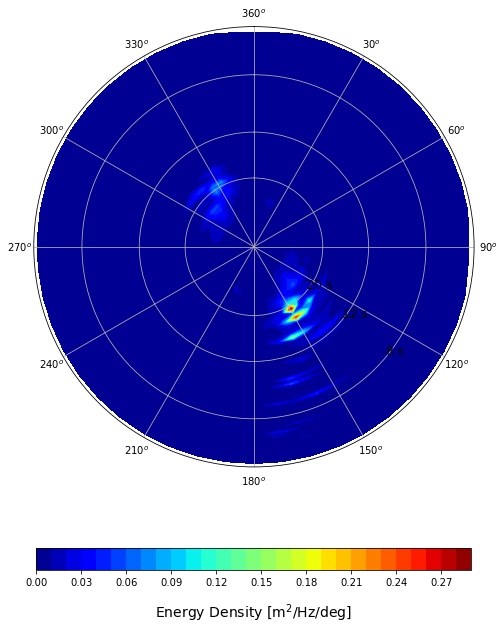

In [19]:
ff,dd = np.meshgrid(Efth.frequency, Efth.direction)

fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(projection='polar'))
cmap = cm.jet
cs = ax.contourf(dd, ff, Efth.T, 30, cmap=cmap)
ax.set_rmax(.16)
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
thetaticks = np.arange(0,360,30)
thetalabels = [str(s)+'$^o$' for s in np.arange(0,360,30)]
thetalabels[0] = '360'+'$^o$'
ax.set_thetagrids(thetaticks, thetalabels)
periods = np.array([20,12,8])
rticks = 1./periods
rlabels = [str(p)+' s' for p in periods]
ax.set_rgrids(rticks)
ax.set_rlabel_position(130)
cbar = plt.colorbar(cs, orientation='horizontal',fraction=0.04, format='%0.2f')
ax.set_yticklabels(rlabels, fontsize=12)
cbar.set_label('Energy Density [m$^2$/Hz/deg]',fontsize=14, labelpad =14)

Now, we could have propagating waves if we add the frequency to the phase


$$
\eta(x, y, t) = \sum_i \sum_j A[\theta_i, \sigma_j] \ cos(k_x[i] x + k_y[i] y + \phi[i, j] + \sigma[j]t)
$$


This will probably take a while to run

In [ ]:
g = 9.81
sig = 2*np.pi*freq # going from linear freq to angular
k = sig**2/g
lmax = 2*np.pi/k.min()
lmin = 2*np.pi/k.max()

L = 2000 # domain length
dx = 5 #grid spacing in x
x = np.arange(0,lmax, dx)
y = x
xx, yy = np.meshgrid(x, y)

nt = 20 
ny, nx = xx.shape
t = np.linspace(0, np.pi, nt);
zeta = np.zeros([nt, ny, nx])
E = np.zeros(nt)
for n in range(nt):
    for i in range(ndir):
        for j in range(nfreq):
            kx = k[j]*np.cos(dir_rad[i]+np.pi)
            ky = k[j]*np.sin(dir_rad[i]+np.pi)
            phi = np.random.random()*2*np.pi # random phases
            zeta[n] += A[i,j]*np.cos(kx*xx + ky*yy + phi + sig[j]*t[n])
            E[n] += A[i,j]**2

In [ ]:
def animate(i):
    ax.contourf(xx, yy, zeta[i], lin, cmap='RdBu_r')

fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(xx, yy, zeta[0], lin, cmap='RdBu_r')
fig.colorbar(cs, format='%.1f')

anim = FuncAnimation(
    fig, animate, interval=200, frames=20)

In [ ]:
rc('animation', html='html5')
HTML(anim.to_html5_video())